# Data assimilation exercise

Load the necessary modules.
Use `Shift-Enter` to execute a cell.

In [92]:
using Random
using LinearAlgebra
using Statistics

using DataAssim
using NCDatasets
using Interpolations
using GeoMapping
using PythonPlot

Download the data (if necessary)

In [93]:
if !isdir("data")
    mkdir("data")
end

if !isfile("data/ensemble_surface.nc")
    download("https://dox.uliege.be/index.php/s/WKweU7pRtPqlwRK/download","data/ensemble_surface.nc")
end

if !isfile("data/LS2v.nc")
    download("https://dox.uliege.be/index.php/s/k2AaF1ETWDGUsg3/download","data/LS2v.nc")
end

Define some helper functions:

Compute the RMS difference between a and b

In [94]:
rms(a,b) = sqrt(mean((a - b).^2))

rms (generic function with 1 method)

`packsv` combines the velocity field with the component u and v
in a single state vector where the corresponding elements of
the masks mask_u and mask_v are true

In [95]:
function packsv(mask_u,mask_v,u,v)
    return [u[mask_u]; v[mask_v]]
end

packsv (generic function with 1 method)

`unpacksv` extracts from a state vector x the compoennts u and v. It is the reverse operation of packsv.


In [96]:
function unpacksv(mask_u,mask_v,x)
    n = sum(mask_u)
    u = fill(NaN,size(mask_u))
    v = fill(NaN,size(mask_v))
    u[mask_u] = x[1:n]
    v[mask_v] = x[n+1:end]
    return u,v
end

unpacksv (generic function with 1 method)

set correct aspect ratio for map

In [97]:
function aspect_ratio()
  if @isdefined PythonPlot
    yl = PythonPlot.PythonCall.pyconvert(Vector,ylim())        
  else
    yl = collect(ylim())    
  end
  gca().set_aspect(1/cos( mean(yl) * pi/180))
end


aspect_ratio (generic function with 1 method)

`km2deg` converts km to arc degree on the surface of the Earth

In [98]:
km2deg(x) = 180 * x / (pi * 6371)

km2deg (generic function with 1 method)

`radarobsloc` computes the location of the radial velocities covered by an HF radar site located at lon0,lat0. The vector r are the ranges (in km) and bearing are the angles (in degree). It also returns the matrix Bearing which has the same size as the matrices lonobs and latobs where the bearing angle is repeated for the different ranges.

In [99]:
function radarobsloc(lon0,lat0,r,bearing)

    sz = (length(r),length(bearing))
    latobs = zeros(sz)
    lonobs = zeros(sz)
    Bearing = zeros(sz)

    for j = 1:length(bearing)
        for i = 1:length(r)
            Bearing[i,j] = bearing[j]
            latobs[i,j],lonobs[i,j] = reckon(lat0, lon0,
                                             km2deg(r[i]), bearing[j])
        end
    end

    return lonobs,latobs,Bearing
end

radarobsloc (generic function with 1 method)

Plot the vector field with the comonents u and v. The parameter legendvec is an optional argument representing the length of the legend vector


In [100]:
function plotvel(u,v; legendvec = 1, color = "k")
    us = (u[1:end-1,2:end-1] + u[2:end,2:end-1]) / 2.
    vs = (v[2:end-1,1:end-1] + v[2:end-1,2:end]) / 2.
    r = 5

    ur = us[1:r:end,1:r:end]
    vr = vs[1:r:end,1:r:end]
    lonr = lon[2:end-1,2:end-1][1:r:end,1:r:end]
    latr = lat[2:end-1,2:end-1][1:r:end,1:r:end]

    ur[end-7,end-3] = legendvec
    vr[end-7,end-3] = 0
    contourf(lon,lat,mask,levels = [0.,0.5],colors = [[.5,.5,.5]])
    quiver(lonr,latr,ur,vr, color = color)
    aspect_ratio()
end

plotvel (generic function with 1 method)

Interpolate and rotate the velocity vertors to compute the radial velcity `ur`.
Return only the radial velocity over sea. Currents towards the antenna are positive.

In [101]:
function interp_radvel(lon_u,lat_u,lon_v,lat_v,us,vs,lonobs,latobs,bearingobs)
    itpu = extrapolate(interpolate((lon_u[:,1],lat_u[1,:]),us,Gridded(Linear())),NaN)
    itpv = extrapolate(interpolate((lon_v[:,1],lat_v[1,:]),vs,Gridded(Linear())),NaN)

    ur = zeros(size(lonobs))
    for i = 1:length(lonobs)
        direction = (bearingobs[i] - 180) * pi/180
        ur[i] = sin(direction) * itpu(lonobs[i],latobs[i]) + cos(direction) * itpv(lonobs[i],latobs[i])
    end
    on_sea = .!isnan.(ur)
    return ur[on_sea],on_sea
end

interp_radvel (generic function with 1 method)

Load the model ensemble

In [102]:
# location of the data
# @__FILE__is the path of the current file
datadir = joinpath(dirname(@__FILE__),"data")

# load the NetCDF varibles u and v
fname = joinpath(datadir,"ensemble_surface.nc")
nc = Dataset(fname)
u = nomissing(nc["u"][:,:,1:40],NaN)
v = nomissing(nc["v"][:,:,1:40],NaN)
close(nc)

closed Dataset

Load the model grid

In [103]:
gridname = joinpath(datadir,"LS2v.nc")
nc = Dataset(gridname);
lon_u = nomissing(nc["lon_u"][:,:])
lat_u = nomissing(nc["lat_u"][:,:])
lon_v = nomissing(nc["lon_v"][:,:])
lat_v = nomissing(nc["lat_v"][:,:])
lon = nomissing(nc["lon_rho"][:,:])
lat = nomissing(nc["lat_rho"][:,:])
# mask is just used for drawing the coastline
mask = nomissing(nc["mask_rho"][:,:])
# mask_u/mask_v are true where a grid cell is a sea point (and zero where it is a land point)
mask_u = nomissing(nc["mask_u"][:,:]) .== 1
mask_v = nomissing(nc["mask_v"][:,:]) .== 1
close(nc)

closed Dataset

# Question 1

Compute the ensemble standard deviation of the velocity vector (see slides).

Hint: The variables `u` and `v` are not defined on the same grid. To interpolate them on the center of every grid cell one can use:

```julia
us = (u[1:end-1,2:end-1,:] + u[2:end,2:end-1,:]) / 2.
vs = (v[2:end-1,1:end-1,:] + v[2:end-1,2:end,:]) / 2.
```


In [104]:
# start here for question 1


In [105]:
size(v)

(276, 149, 40)

In [106]:
us = (u[1:end-1,2:end-1,:] + u[2:end,2:end-1,:]) / 2.
vs = (v[2:end-1,1:end-1,:] + v[2:end-1,2:end,:]) / 2.
size(us), size(vs)

((274, 148, 40), (274, 148, 40))

# Question 2


What is the __probability__ that the speed (norm of the velocity vector) exceeds 20 cm/s assuming that the ensemble members are a sample of the model probability distribution function (pdf)?


In [107]:
# start here for question 2

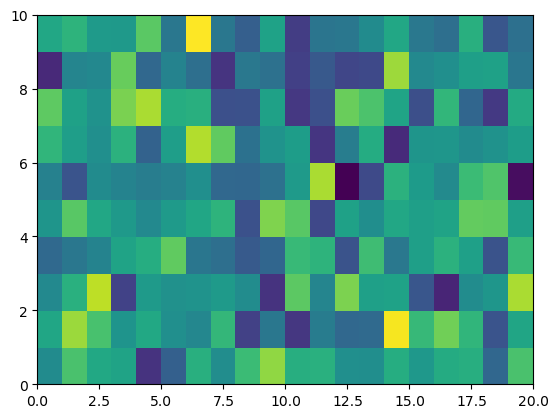

Python: (0.0, 20.0)

In [108]:
pcolor(randn(10,20))
a= xlim()

In [109]:
mean(collect(a))


Python: 10.0

In [110]:
typeof(a)

PythonCall.Py

In [111]:
a

Python: (0.0, 20.0)

# Question 3

3) Simplified __twin experiment__:
   * Let's assume that the last ensemble member is the reality (true current)
   * The last ensemble member will be used to extract observations, but it will not be used during the analysis
   * Assimilate radial observations of two HF radar sites
   * Optimize the __position and orientation__ of two HF radar sites by minimizing the RMS error (as defined below). We assume that the field of view of the HF Radar 120 degrees but the orientation of the antenna can be chosen freely. The range of HF radar is fixed to 100 km with a radial resolution of 5 km.
   * Validate the mean of the analysis ensemble with the true currents


Define the location of the HF radar and choose a group name

In [112]:
groupname = "Alex" # <- put here your group name

sitelon1 = 9.84361
sitelat1 = 44.04167
siteorientation1 = 240

sitelon2 = 10.46
sitelat2 = 43.37
siteorientation2 = 240

240

The following code does not need to be changed

In [113]:
# distances from HF radar site in km
ranges = 5:5:100

lonobs1,latobs1,bearingobs1 = radarobsloc(sitelon1,sitelat1,ranges,siteorientation1 .+ (-60:5:60))
lonobs2,latobs2,bearingobs2 = radarobsloc(sitelon2,sitelat2,ranges,siteorientation2 .+ (-60:5:60))

([10.460000000000012 10.454612772489154 … 10.403920825920276 10.40641028287224; 10.460000000000012 10.449233484245461 … 10.347806526863685 10.35278083391713; … ; 10.460000000000012 10.358977325588642 … 9.388495442080592 9.434986089523397; 10.460000000000012 10.35373691604665 … 9.331750028739114 9.38063884150536], [43.325033919704055 43.325204902728366 … 43.388989789485244 43.39247053248726; 43.28006783940812 43.28040955299537 … 43.407952160985985 43.41491602417816; … ; 42.515644474377204 42.51885071257877 … 43.72608324335641 43.79262097988797; 42.47067839408127 42.47405094686133 … 43.744546040387384 43.81460917128673], [180.0 185.0 … 295.0 300.0; 180.0 185.0 … 295.0 300.0; … ; 180.0 185.0 … 295.0 300.0; 180.0 185.0 … 295.0 300.0])

Area measured by the HF radar

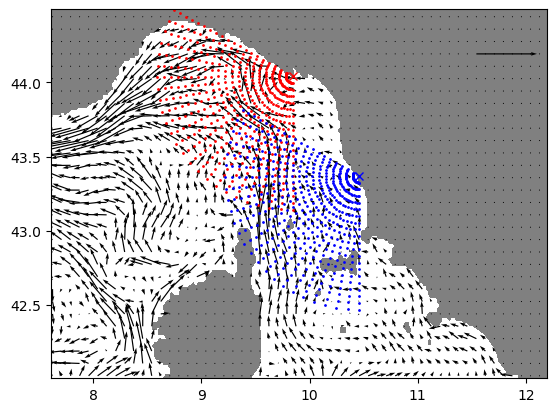

In [114]:
plot(sitelon1,sitelat1,"rx")
plot(lonobs1,latobs1,".r",markersize = 2)
plot(lonobs2,latobs2,".b",markersize = 2)
plot(sitelon2,sitelat2,"bx")

plotvel(u[:,:,1],v[:,:,1]; legendvec = 1);

The last ensemble member is assumed to be the true state

In [115]:
bearingobs = bearingobs1[:]
lonobs = lonobs1[:]
latobs = latobs1[:]

bearingobs = [bearingobs1[:]; bearingobs2[:]]
lonobs = [lonobs1[:]; lonobs2[:]]
latobs = [latobs1[:]; latobs2[:]]

# the true state
xt = packsv(mask_u,mask_v,u[:,:,end],v[:,:,end])

# number of elements in the state vector
n = sum(mask_u) + sum(mask_v)

# Ensemble size
Nens = size(u,3)-1

# Matrix with all ensemble members in "packed" form
Xf = zeros(n,Nens)
for n = 1:Nens
    Xf[:,n] = packsv(mask_u,mask_v,u[:,:,n],v[:,:,n])
end

# ensemble mean
xf = mean(Xf, dims = 2)

# extract observations
yo,on_sea = interp_radvel(lon_u,lat_u,lon_v,lat_v,u[:,:,end],v[:,:,end],lonobs,latobs,bearingobs)

R = Diagonal(fill(0.01,size(yo)))

# set the seed
Random.seed!(12345)

# add noise to yo
yo = yo + sqrt(R) * randn(size(yo))

HXf = zeros(length(yo),size(u,3)-1)

# apply the observation operator to every velocity field
for i = 1:Nens
    HXf[:,i],on_sea = interp_radvel(lon_u,lat_u,lon_v,lat_v,u[:,:,i],v[:,:,i],lonobs,latobs,bearingobs)
end

# apply the ETKF

Xa,xa = ETKF(Xf,HXf,yo,R,[])

# extract the velocity from the state vector
uf,vf = unpacksv(mask_u,mask_v,xf)
ua,va = unpacksv(mask_u,mask_v,xa)

([0.015500469423426456 0.00393157246592904 … NaN NaN; 0.02706932452542397 0.03428629259662735 … NaN NaN; … ; NaN NaN … NaN NaN; NaN NaN … NaN NaN], [-0.1666156391260506 -0.18223363265702136 … NaN NaN; -0.15099773120718168 -0.16580966592161886 … NaN NaN; … ; NaN NaN … NaN NaN; NaN NaN … NaN NaN])

In [116]:
# compute the RMS errors
@show rms(xf,xt)
@show rms(xa,xt)

rms(xf, xt) = 0.09872131042927046
rms(xa, xt) = 0.06814490688083578


0.06814490688083578

Plot all radial measurements

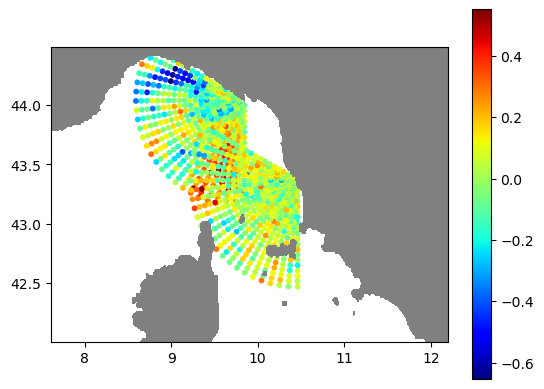

Python: None

In [117]:
scatter(lonobs[on_sea],latobs[on_sea],10,yo; cmap="jet"); colorbar();
contourf(lon,lat,mask,levels = [0.,0.5],colors = [[.5,.5,.5]])
aspect_ratio()

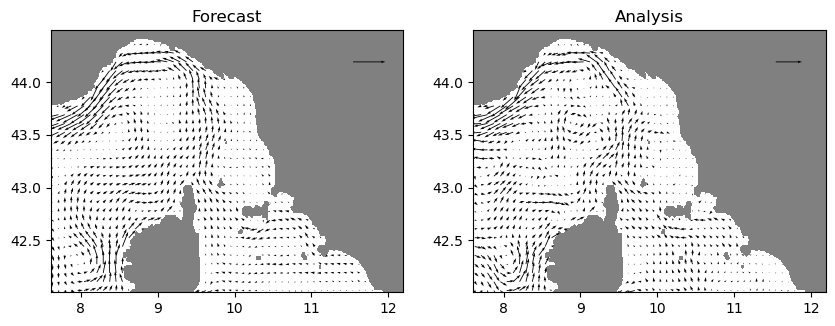

In [118]:
figure(figsize=(10,4))
subplot(1,2,1); plotvel(uf,vf; legendvec = 1); title("Forecast")
subplot(1,2,2); plotvel(ua,va; legendvec = 1); title("Analysis");


A function to submit the RMS error to score board:
http://data-assimilation.net/scores/?game=OGCB2024

In [119]:
function submit_results(groupname,
                        sitelon1,sitelat1,siteorientation1,
                        sitelon2,sitelat2,siteorientation2,rms_velocity)
    function myescape(str)
        for (s1,s2) in Dict("{" => "%7B", "}" => "%7D", "\"" => "%22", " " => "%20")
            str = replace(str,s1 => s2)
        end
        return str
    end
    myjson(data) = "{" * join(["\"$k\":$(string(v))" for (k,v) in data],",") * "}"
    game = "OGCB2024"

    data_dict = Dict(
                      "sitelon1" => sitelon1,
                      "sitelat1" => sitelat1,
                      "siteorientation1" => siteorientation1,
                      "sitelon2" => sitelon2,
                      "sitelat2" => sitelat2,
                      "siteorientation2" => siteorientation2)
    
    #=
    data = JSON.json(data_dict)
    groupname_esc = URIParser.escape(groupname)
    data_esc = URIParser.escape(data)
    =#
    data = myjson(data_dict)    
    groupname_esc = myescape(groupname)
    data_esc = myescape(data)
    baseurl = "http://data-assimilation.net/scores"
    URL = "$(baseurl)/new?game=$(game)&name=$(groupname_esc)&value=$(rms_velocity)&data=$(data_esc)"
    rm(download(URL))
    println("Check scores at: $(baseurl)/?game=$(game)\n")
end


submit_results (generic function with 1 method)

In [120]:
rms_velocity = rms(xa,xt)
@show rms_velocity
submit_results(groupname,
               sitelon1,sitelat1,siteorientation1,
               sitelon2,sitelat2,siteorientation2,rms_velocity)


rms_velocity = 0.06814490688083578
Check scores at: http://data-assimilation.net/scores/?game=OGCB2024

